In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
from sklearn import datasets, cross_validation, metrics
from classifier import KernelNullSpaceClassifier

In [2]:
PATH = r'../../../projects/weiyen/data/bow_1000_dense_subset/'

In [3]:
ds = datasets.load_files(PATH)
ds.data = np.vstack([np.fromstring(txt, sep='\t') for txt in ds.data])

idx = ds.target.argsort()
ds.data = ds.data[:, idx]
ds.target = ds.target[idx]


In [4]:
# Train novelty classifier
# Randomly select a few classes to represent the "novel" class.
data = ds.data
target = ds.target

classes = np.unique(target)
num_class = len(classes)
num_novel = max(np.floor(num_class*0.2), 1) # 20% of classes will be "novel"
novel = np.random.choice(target, num_novel)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
    data, target, test_size=0.4, random_state=0)

# Remove all instances of the novel classes from the training set
mask = np.array([y not in novel for y in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

# Test labels are 1 if novel, otherwise 0.
y_test = np.array([1 if cl in novel else 0 for cl in y_test])

X_train = data
y_train = target

/Users/cong/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
def _hik(x, y):
    '''
    Implements the histogram intersection kernel.
    '''
    return np.minimum(x, y).sum()


In [15]:
from numpy.linalg import svd

def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A, full_matrices=False)
    print(s)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    print("nnz:", nnz)
    ns = vh[nnz:].conj().T
    return ns


In [8]:
from sklearn.preprocessing import KernelCenterer

In [40]:
K = metrics.pairwise_kernels(X_train, metric=_hik)
labels = y_train
n, m = K.shape
np.diag(K)

array([  1251.,   3312.,   1651.,   1447.,   3749.,   2551.,   1076.,
          752.,   1907.,   3868.,   1877.,    963.,   1037.,   1907.,
         7180.,   2708.,   2978.,   1499.,    435.,   2178.,   1571.,
         2295.,   6751.,   7294.,   3129.,   3603.,   2428.,   5833.,
         1034.,   1431.,   2152.,   4283.,   3346.,    894.,   8100.,
         1248.,   5718.,   2636.,   3062.,   3516.,   1420.,   5558.,
          990.,   1706.,   4293.,  10909.,   1465.,   5831.,  14982.,
         3889.,   1927.,   2447.,   3928.,   1933.,   1290.,   3313.,
         1384.,   1647.,   1023.,   3719.,   1826.,   5177.,    632.,
         1528.,    986.,   1508.,  10335.,   2286.,   6898.,   7307.,
          888.,   4880.,   1063.,   1860.,   2127.,   5585.,   2262.,
          908.,    607.,   1907.,   1048.,   2175.,   1508.,   1041.,
         4781.,   1247.,   1203.,   7056.,    689.,   3644.,   5227.,
         1809.,  15920.,   1802.,   1201.,   1394.,    860.,   2250.,
        14731.,    9

In [38]:
classes = np.unique(labels)
    
centered_k = KernelCenterer().fit_transform(K)
basis_values, basis_vecs = np.linalg.eig(centered_k)

idx = basis_values.argsort()[::-1]
basis_values = basis_values[idx]
basis_vecs = basis_vecs[:, idx]

basis_vecs = basis_vecs[:,basis_values > 1e-12]
basis_values = basis_values[basis_values > 1e-12]
 
basis_values = np.diag(1.0/np.sqrt(basis_values))
basis_vecs  = basis_vecs.dot(basis_values)

L = np.zeros([n,n])
for cl in classes:
    for idx1, x in enumerate(labels == cl):
        for idx2, y in enumerate(labels == cl):
            if x and y:
                L[idx1, idx2] = 1.0/np.sum(labels==cl)
    
M = np.ones([m,m])/m
H = ((np.eye(m,m)-M).dot(basis_vecs)).T.dot(K).dot(np.eye(n,m)-L)
    
t_sw = H.dot(H.T)

<IPython.core.display.Javascript object>


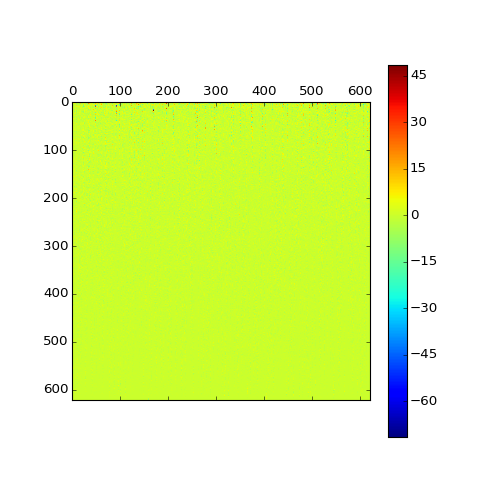

In [39]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.matshow(H)
plt.colorbar()

In [29]:
t_sw[:5,:5]

array([[  1.03924562e+00+0.j,   1.58268501e-03+0.j,  -2.21373424e-04+0.j,
          5.18395112e-03+0.j,   1.67991023e-03+0.j],
       [  1.58268501e-03+0.j,   1.01845430e+00+0.j,  -2.80197314e-03+0.j,
         -4.95452411e-03+0.j,  -2.58776237e-03+0.j],
       [ -2.21373424e-04+0.j,  -2.80197314e-03+0.j,   1.01789562e+00+0.j,
         -1.29607360e-03+0.j,  -1.35556311e-03+0.j],
       [  5.18395112e-03+0.j,  -4.95452411e-03+0.j,  -1.29607360e-03+0.j,
          1.00607666e+00+0.j,  -8.41765016e-04+0.j],
       [  1.67991023e-03+0.j,  -2.58776237e-03+0.j,  -1.35556311e-03+0.j,
         -8.41765016e-04+0.j,   1.00757713e+00+0.j]])

In [18]:
eigenvecs = nullspace(t_sw)

LinAlgError: SVD did not converge

In [5]:
classifier = KernelNullSpaceClassifier(threshold=0.5).fit(X_train, y_train)
y_score = classifier.predict(X_test)
y_score

LinAlgError: SVD did not converge

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)

In [ ]:
fpr

In [ ]:
thresholds